In [5]:
import nbimporter

In [23]:
from notebooks.dataset import load_datasets 
from notebooks.model import get_model  
import torch
import torch.optim as optim
import torch
import torch.nn as nn

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, val_loader, test_loader = load_datasets("pedestrian_risk_analysis.csv")

Using cache found in /home/nhansen3/.cache/torch/hub/pytorch_vision_v0.10.0
/packages/miniconda-t2/20230523/envs/jupyter-cuda121-20230610/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/packages/miniconda-t2/20230523/envs/jupyter-cuda121-20230610/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


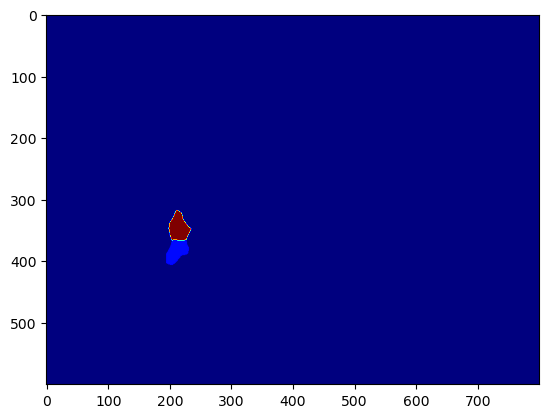

In [25]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

model = torch.hub.load("pytorch/vision:v0.10.0", "deeplabv3_resnet101", pretrained=True)
model.eval()

image = Image.open("DAVID-sim/m1596437/Images/Video_002/v002_0002.png")
transform = T.Compose([T.ToTensor()])
image_tensor = transform(image).unsqueeze(0)

with torch.no_grad():
    output = model(image_tensor)["out"][0]  # Get segmentation map

output_predictions = output.argmax(0)

plt.imshow(output_predictions, cmap="jet")
plt.show()


In [12]:
import torch.nn as nn
import torchvision.models as models
import torch

model = models.segmentation.deeplabv3_resnet101(pretrained=True)

in_channels = model.classifier[4].in_channels 

model.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d((2, 2)),  
    nn.Flatten(),  
    nn.Linear(in_channels, 3)  
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [13]:
#print(model)

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [15]:
def train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)["out"]  
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

        validate(model, val_loader, criterion, device)

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)["out"]
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_acc:.2f}%")

train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 9.50 GiB of which 10.94 MiB is free. Process 3096096 has 110.00 MiB memory in use. Process 3118724 has 610.00 MiB memory in use. Including non-PyTorch memory, this process has 8.87 GiB memory in use. Of the allocated memory 8.76 GiB is allocated by PyTorch, and 16.21 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF